In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/zoo-animal-classification/class.csv
/kaggle/input/zoo-animal-classification/zoo.csv


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, classification_report, accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn

%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
class_data = pd.read_csv("/kaggle/input/zoo-animal-classification/class.csv")
data = pd.read_csv("/kaggle/input/zoo-animal-classification/zoo.csv")

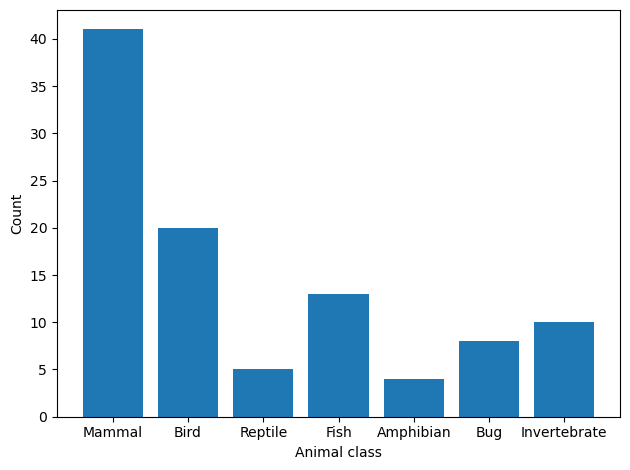

In [4]:
#Basical representation of class counts, observe the unbalanced count for mammals and others

plt.bar(class_data["Class_Type"], class_data["Number_Of_Animal_Species_In_Class"])
plt.ylabel('Count')
plt.xlabel('Animal class')
plt.tight_layout()
plt.show()

In [5]:
#Analyzing the specification of the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   animal_name  101 non-null    object
 1   hair         101 non-null    int64 
 2   feathers     101 non-null    int64 
 3   eggs         101 non-null    int64 
 4   milk         101 non-null    int64 
 5   airborne     101 non-null    int64 
 6   aquatic      101 non-null    int64 
 7   predator     101 non-null    int64 
 8   toothed      101 non-null    int64 
 9   backbone     101 non-null    int64 
 10  breathes     101 non-null    int64 
 11  venomous     101 non-null    int64 
 12  fins         101 non-null    int64 
 13  legs         101 non-null    int64 
 14  tail         101 non-null    int64 
 15  domestic     101 non-null    int64 
 16  catsize      101 non-null    int64 
 17  class_type   101 non-null    int64 
dtypes: int64(17), object(1)
memory usage: 14.3+ KB


In [6]:
data.head()

,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1


In [7]:
class_data.head()

,Class_Number,Number_Of_Animal_Species_In_Class,Class_Type,Animal_Names
0,1,41,Mammal,"aardvark, antelope, bear, boar, buffalo, calf,..."
1,2,20,Bird,"chicken, crow, dove, duck, flamingo, gull, haw..."
2,3,5,Reptile,"pitviper, seasnake, slowworm, tortoise, tuatara"
3,4,13,Fish,"bass, carp, catfish, chub, dogfish, haddock, h..."
4,5,4,Amphibian,"frog, frog, newt, toad"


In [8]:
#DATA PREPARATION

features = data.drop(["animal_name", "class_type"], axis=1).values
labels = data["class_type"].values - 1
class_names = np.unique(class_data["Class_Type"].values)
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.33, random_state = 42, shuffle = True)#

print(f"Size of train features data: {X_train.shape}; size of labels data: {y_train.shape}")
print(f"Size of test features data: {X_test.shape}; size of labels data: {y_test.shape}")

Size of train features data: (67, 16); size of labels data: (67,)
Size of test features data: (34, 16); size of labels data: (34,)


In [9]:
#Since the number of animals of some classes is unbalanced, we will use weighted CrossEntropyLoss.
#Let's compute the weights for it:

def compute_weights(labels):
    
    counts = np.bincount(labels)
    scores = np.sqrt(len(labels) / counts)
    weights = torch.from_numpy(scores / np.sum(scores)).float()
    
    return weights

cross_entropy_weights = compute_weights(y_train)

In [10]:
class FCNNet(nn.Module):
    def __init__(self, n_features, n_classes):
        super(FCNNet, self).__init__()
        
        self.fc1 = nn.Linear(n_features, 64)
        self.fc2 = nn.Linear(64, 32)
        self.out = nn.Linear(32, n_classes)
        
        self.dropout = nn.Dropout(p = 0.1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        
        x = self.relu(self.dropout(self.fc1(x)))
        x = self.relu(self.dropout(self.fc2(x)))
        x = self.out(x)
        
        return x

In [11]:
learning_rate = 0.01
epochs = 9
n_features = X_train.shape[1]
n_classes = len(np.unique(y_train))
batch_size = 34

animal_classifier = FCNNet(n_features, n_classes)

#Basical parameters for the NN-model:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
criterion = nn.CrossEntropyLoss(weight = cross_entropy_weights).to(device)
optimizer = torch.optim.Adam(animal_classifier.parameters(), lr = learning_rate)

animal_classifier.to(device)

FCNNet(
  (fc1): Linear(in_features=16, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=7, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (relu): ReLU()
)

In [12]:
#TRAIN LOOP
def train(model, optimizer, criterion, X_train, y_train, num_epochs = epochs, batch_size = batch_size, device = device):
    
    train_accuracy = []
    train_loss = []
    train_f1_score = []
    
    for epoch in range(epochs):
        for i in range(0, X_train.shape[0], batch_size):
        
            features = torch.from_numpy(X_train[i:batch_size + i, :]).float().to(device)
            targets = torch.from_numpy(y_train[i:batch_size+i]).long().to(device)
        
            predictions = model.forward(features)
            loss = criterion(predictions, targets)
        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
            pred_labels = torch.argmax(predictions, dim = 1)
        
        f1 = f1_score(targets.numpy(), pred_labels.numpy(), average = "macro")
        acc = accuracy_score(targets.numpy(), pred_labels.numpy())
        
        train_loss.append(loss.item())
        train_accuracy.append(acc)
        train_f1_score.append(f1)
        
    
    return train_accuracy, train_loss, train_f1_score

In [13]:
train_accuracy, train_loss, train_f1_score = train(animal_classifier, optimizer, criterion, X_train, y_train, num_epochs = epochs, batch_size = batch_size, device = device)

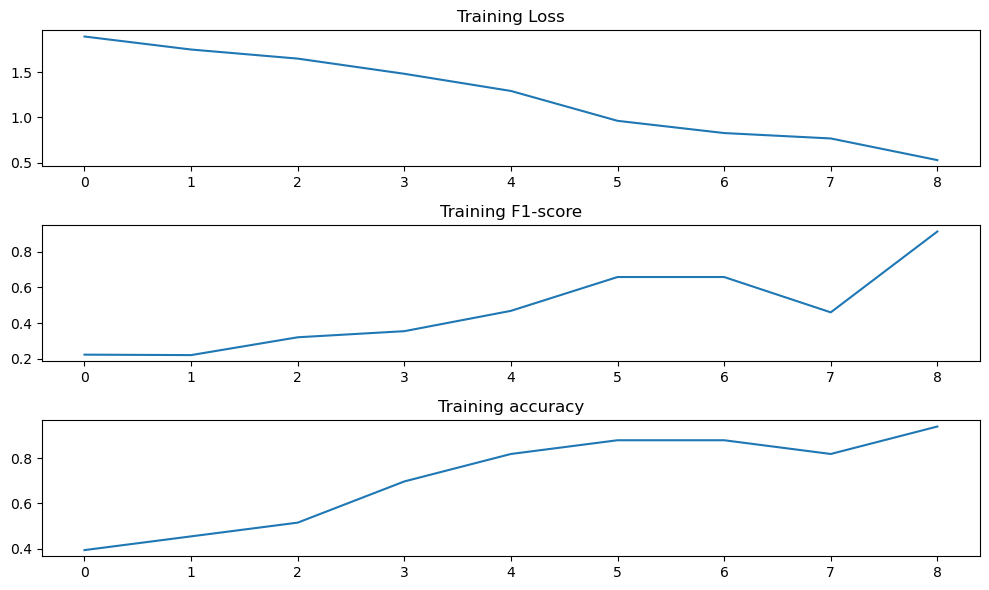

In [14]:
#VISUALIZING TRAIN STATISTICS 

fig, ax =  plt.subplots(3, 1, figsize=(10, 6))
ax[0].plot(train_loss)
ax[0].set_title('Training Loss')
ax[1].plot(train_f1_score)
ax[1].set_title('Training F1-score')
ax[2].plot(train_accuracy)
ax[2].set_title('Training accuracy')
plt.tight_layout()
plt.show()

In [15]:
#MODEL VALIDATION

def test(model, criterion, X_test, y_test, batch_size = batch_size, device = device):
    model.eval()
    with torch.no_grad():
        net_predictions = []
        test_loss = []
        
        for i in range(0, X_test.shape[0], batch_size):
            
            features = torch.from_numpy(X_test[i:batch_size + i, :]).float().to(device)
            targets = torch.from_numpy(y_test[i:batch_size+i]).long().to(device)
            
            predictions = model.forward(features)
            loss = criterion(predictions, targets)
        
            pred_labels = torch.argmax(predictions, dim = 1)
            test_loss.append(loss.item())
        
            net_predictions.extend(pred_labels.numpy())
        
        test_f1_score = f1_score(targets.numpy(), pred_labels.numpy(), average = "macro")
        test_accuracy = accuracy_score(targets.numpy(), pred_labels.numpy())
        
    return {
        "predictions": net_predictions,
        "targets" : y_test,
        "accuracy" : test_accuracy,
        "f1" : test_f1_score,
        "loss" : test_loss
    }

In [16]:
#FINAL STATISTICS  

results = test(animal_classifier, criterion, X_test, y_test)

print(f"Final accuracy : " + str(results["accuracy"]*100) +"%")
print(f"Final F1-score : " + str(results["f1"]*100) +"%")

Final accuracy : 88.23529411764706%
Final F1-score : 69.65367965367966%


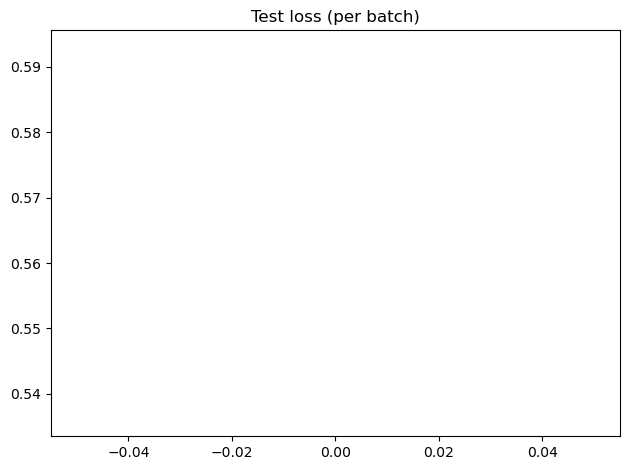

In [17]:
#VISUALIZING TEST STATISTICS 

plt.plot(results["loss"])
plt.title('Test loss (per batch)')
plt.tight_layout()
plt.show()

<Axes: >

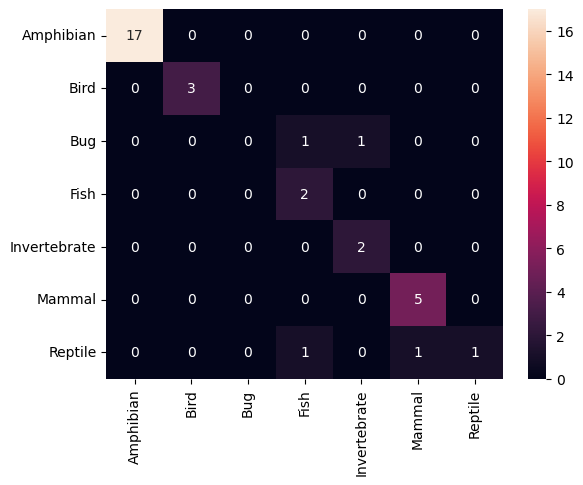

In [18]:
conf_matrix = confusion_matrix(results["targets"], results["predictions"])
sns.heatmap(conf_matrix, annot = True, cbar = True, xticklabels=class_names,
            yticklabels=class_names)

In [19]:
print(classification_report(results["targets"], results["predictions"], zero_division = True))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00         3
           2       1.00      0.00      0.00         2
           3       0.50      1.00      0.67         2
           4       0.67      1.00      0.80         2
           5       0.83      1.00      0.91         5
           6       1.00      0.33      0.50         3

    accuracy                           0.88        34
   macro avg       0.86      0.76      0.70        34
weighted avg       0.93      0.88      0.85        34

